In [21]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tqdm import tqdm

In [22]:
ORIGINAL_DATA_DIR = 'Private_Dataset'
SAVE_AUGMENTED_DIR = 'Augmented_Dataset'

In [23]:
if not os.path.exists(SAVE_AUGMENTED_DIR):
    os.makedirs(SAVE_AUGMENTED_DIR)

In [24]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [25]:
for class_name in os.listdir(ORIGINAL_DATA_DIR):
    class_path = os.path.join(ORIGINAL_DATA_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    new_class_dir = os.path.join(SAVE_AUGMENTED_DIR, class_name)
    os.makedirs(new_class_dir, exist_ok=True)

    # Initialize count for each class
    count = 0
    num_original_images = len(os.listdir(class_path))

    # Generate 10x the amount of original data
    for batch in tqdm(train_datagen.flow_from_directory(
        os.path.dirname(class_path),
        classes=[class_name],
        batch_size=1,
        target_size=(150, 150),
        save_to_dir=new_class_dir,   # This saves the files
        save_prefix='aug',
        save_format='jpeg'
    ), total=num_original_images * 10):
        count += 1
        if count >= 2 * num_original_images:
            break

Found 12 images belonging to 1 classes.


 19%|█▉        | 23/120 [00:01<00:04, 19.46it/s]

Found 7 images belonging to 1 classes.



 19%|█▊        | 13/70 [00:00<00:01, 33.40it/s]


Found 17 images belonging to 1 classes.


 19%|█▉        | 33/170 [00:01<00:07, 18.96it/s]


In [26]:
train_generator = train_datagen.flow_from_directory(
    'Augmented_Dataset',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

Found 216 images belonging to 3 classes.


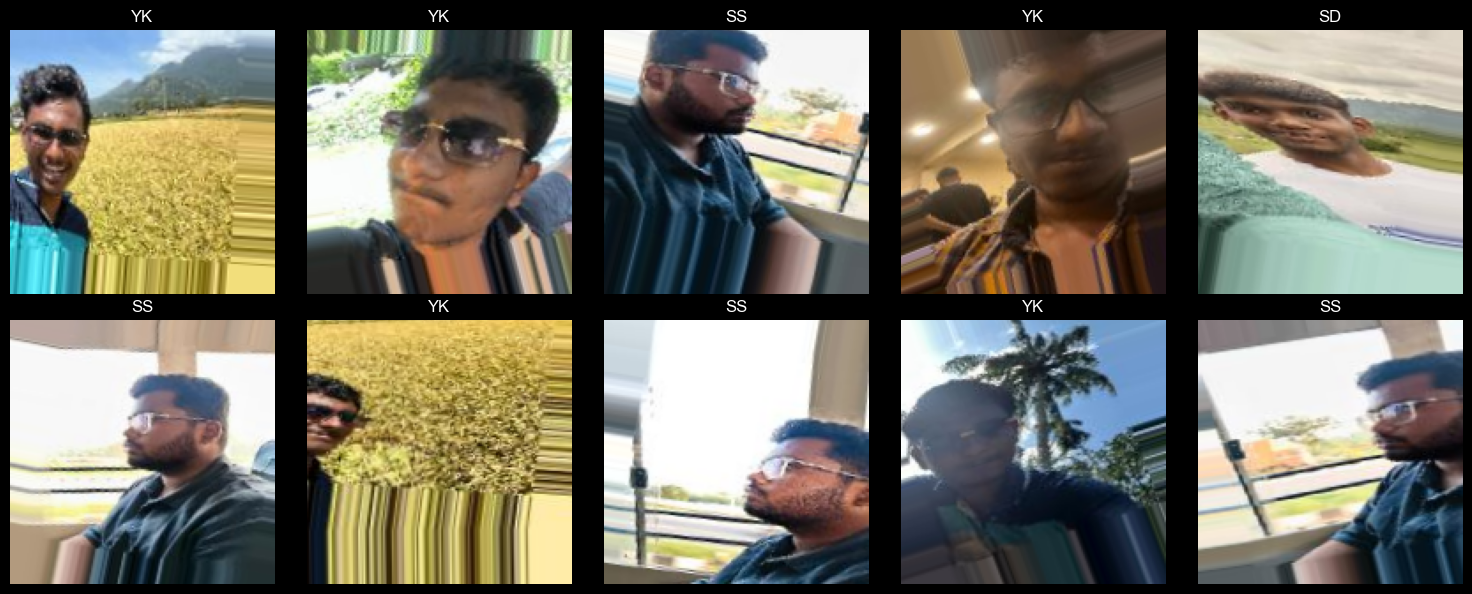

In [27]:
NUM_TO_SHOW = 10
collected_images = []
collected_labels = []

while len(collected_images) < NUM_TO_SHOW:
    batch_x, batch_y = next(train_generator)
    for img, lbl in zip(batch_x, batch_y):
        collected_images.append(img)
        collected_labels.append(lbl)
        if len(collected_images) >= NUM_TO_SHOW:
            break

class_indices = train_generator.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}
label_names = [inv_class_indices[int(np.argmax(lbl))] for lbl in collected_labels]

plt.figure(figsize=(15, 6))
for i, img in enumerate(collected_images):
    ax = plt.subplot(2, 5, i + 1)
    img_to_show = np.clip(img, 0.0, 1.0)
    plt.imshow((img_to_show * 255).astype('uint8'))
    plt.title(label_names[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [28]:
class_names = list(class_indices.keys())

In [30]:
import tensorflow.keras as keras
from tensorflow.keras import layers
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

/opt/miniconda3/envs/mltraining/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
model.fit(train_generator, epochs=10, batch_size=32)
model.save('cnn_multi-class_classifier.h5')

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 872ms/step - accuracy: 0.4074 - loss: 1.3814
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 749ms/step - accuracy: 0.5509 - loss: 0.9204
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 779ms/step - accuracy: 0.6991 - loss: 0.7218
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 803ms/step - accuracy: 0.7500 - loss: 0.6413
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 677ms/step - accuracy: 0.7963 - loss: 0.5396
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 671ms/step - accuracy: 0.8102 - loss: 0.4782
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 763ms/step - accuracy: 0.8704 - loss: 0.3962
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 853ms/step - accuracy: 0.8287 - loss: 0.3979
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 757ms/step - accuracy: 0.8704 - loss: 0.3278
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 772ms/step - accuracy: 0.9074 - loss: 0.2642
